# Binary Classification of 747 vs A380
The goal is to classify a picture between two classes : an Boeing 747 or an Airbus A380.
*Spoiler :* This source code is 3 times better than Google AutoML on the same dataset !

## Dataset
It's an homemade dataset from Google Image.
There is a nice script to get images from Google : https://github.com/boxabirds/fastai-helpers/blob/master/training-data-generator.py, it's based on https://github.com/hardikvasa/google-images-download wich use ChromeDriver to automate the process.

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
PATH = "../../datasets/boeing_vs_airbus/"
!rm -r {PATH}tmp
## Getting dataset
#!mkdir {PATH}
#!pip install google_images_download
#!ls ../../datasets/
#!cd {PATH} && mkdir -p train/747 train/A380 test/747 test/A380  valid/747 valid/A380
#!cd {PATH}/747 && googleimagesdownload --keywords "Boing 747" --limit 1000 --chromedriver /usr/local/bin/chromedriver
#!cd {PATH}/A380 && googleimagesdownload --keywords "Airbus A380" --limit 1000 --chromedriver /usr/local/bin/chromedriver
## Getting models weights
#!cd ./fastai && wget http://files.fast.ai/models/weights.tgz && tar -xvzf weights.tgz
#!ls {PATH}

In [3]:
print("Setting CUDA devices...")
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="5"
print("Loading Fast.AI modules...")
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from sklearn.metrics import confusion_matrix

sz=299
arch=resnext50
#arch=resnet34
bs=132

def plot_ep_vals(ep_vals):
    plt.ylabel("loss")
    plt.xlabel("epoch")
    epochs = len(ep_vals)#ep_vals.keys()
    #plt.xticks(np.asarray(list(epochs)))
    plt.xticks((list(ep_vals)))
    #print((list(ep_vals)))
    trn_losses = [item[0] for item in list(ep_vals.values())]
    #print(trn_losses)
    val_losses = [item[1] for item in list(ep_vals.values())]
    #print(val_losses)
    plt.plot(list(ep_vals), trn_losses, c='b', label='train')
    plt.plot(list(ep_vals), val_losses, c='r', label='validation')
    plt.legend(loc='upper left')

def plot_the_confusion_matrix():
    log_preds,y = learn.TTA()
    probs = np.mean(np.exp(log_preds),0)
    accuracy_np(probs, y)
    preds = np.argmax(probs, axis=1)
    probs = probs[:,1]
    cm = confusion_matrix(y, preds)
    plot_confusion_matrix(cm, data.classes)
    # precission = VP / (VP + FP)
    precision = cm[0][0]/(cm[0][1]+cm[0][0]);
    print("Precision : ", precision)
    # recall =  = VP / (VP + FN)
    recall = cm[0][0]/(cm[1][0]+cm[0][0]);
    print("Recall : ", recall)
    F1 = 2 * ((precision*recall)/(precision + recall))
    print("F1 : ", F1)
    F2 = 5 * ((precision*recall)/(4*precision + recall))
    print("F2 : ", F2)
    return cm

Setting CUDA devices...
Loading Fast.AI modules...


/home/ben/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
print("CuDNN optimization is ", torch.backends.cudnn.enabled)

CuDNN optimization is  True


# Training from sratch
We begin with an empty ResNext50 model.
First we compute the mean and standard deviation of all images to center them.
## Computing mean and stddev

In [5]:

import glob
import PIL
means = np.array([0.0,0.0,0.0])
files = [val for sublist in [[os.path.join(i[0], j) for j in i[2]] for i in os.walk(f'{PATH}train')] for val in sublist]
print("Input images number : ", len(files))
deviations = np.array([0.0,0.0,0.0])
#variances = np.array([0,0,0])
variance = np.array([0.0,0.0,0.0])
for image in files:
    #print(image)
    img_stats = PIL.ImageStat.Stat(PIL.Image.open(image), mask=None)
    means += np.array(img_stats.mean)
    variance += np.array(img_stats.var)

stddev = np.sqrt(variance) / len(files)
print("stddev with PIL : ", stddev)

mean = np.array(means) / len(files) / 255
print("Means with PIL : ", mean)
stats = (mean, stddev)

Input images number :  1310


/home/ben/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


stddev with PIL :  [1.54975 1.51391 1.60444]
Means with PIL :  [0.53286 0.5643  0.59667]


### Prepare data an model

In [6]:
image_size=128
#stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))
tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomFlip()], pad=sz//8)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=4, num_workers=num_cpus())
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5, pretrained=False)

In [7]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 299, 299]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 150, 150]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 150, 150]),
                           ('output_shape', [-1, 64, 75, 75]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 75, 

The model is realy deep as it make use of 168 layers.

How much input data do we get ?

(array([666.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 644.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

(array([155.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 155.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

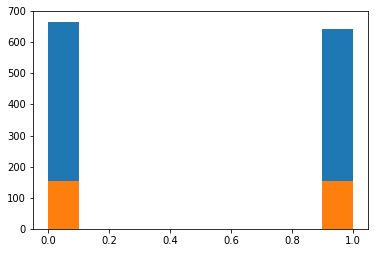

In [8]:
# This is the label for a val data
plt.hist(data.trn_y)
plt.hist(data.val_y)

/home/ben/anaconda3/envs/fastai/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:764: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


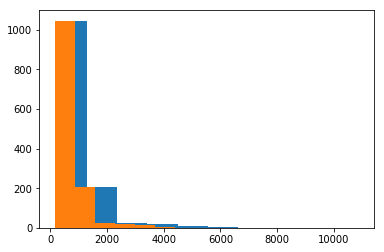

In [9]:
size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}
row_sz, col_sz = list(zip(*size_d.values()))
row_sz = np.array(row_sz)
col_sz = np.array(col_sz)
plt.hist(row_sz);
plt.hist(col_sz);

(array([ 23.,  51.,  49.,  74., 119., 179.,  77., 100.,  33.,  59.]),
 array([220. , 297.2, 374.4, 451.6, 528.8, 606. , 683.2, 760.4, 837.6, 914.8, 992. ]),
 <a list of 10 Patch objects>)

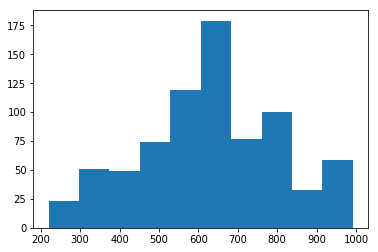

In [10]:
plt.hist(row_sz[row_sz < 1000])

We have few data, but sizes are good.

### Guess learning rate

 90%|█████████ | 296/328 [00:23<00:02, 12.84it/s, loss=1.92] 

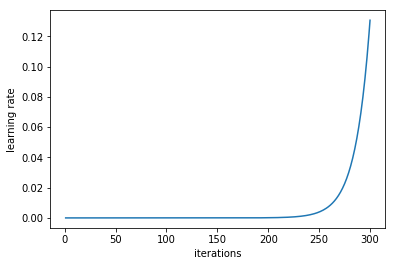

In [11]:
lrf=learn.lr_find(1e-10, end_lr=1)
learn.sched.plot_lr()

In [12]:
#?learn.lr_find

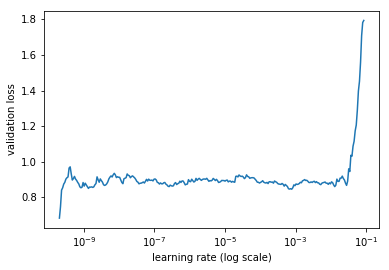

In [13]:
learn.sched.plot()

Unfortunatly the learning rate finder do not work with small dataset

epoch      trn_loss   val_loss   accuracy                    
    0      0.845312   0.691452   0.522581  
    1      0.823532   0.682966   0.56129                     
    2      0.807569   0.691801   0.53871                     
    3      0.757487   0.686261   0.558065                    
    4      0.733489   0.690579   0.519355                    
    5      0.764669   0.686866   0.548387                    
    6      0.720179   0.69007    0.532258                    
    7      0.734215   0.684599   0.564516                    
    8      0.711056   0.685868   0.56129                     
    9      0.721402   0.687246   0.548387                    
    10     0.688695   0.689937   0.509677                    
    11     0.706815   0.688964   0.519355                    
    12     0.718874   0.689572   0.554839                    
    13     0.704062   0.693395   0.506452                    
    14     0.727434   0.688103   0.554839                    
    15     0.697599   0.69

/home/ben/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in long_scalars


array([[  0, 155],
       [  0, 155]])

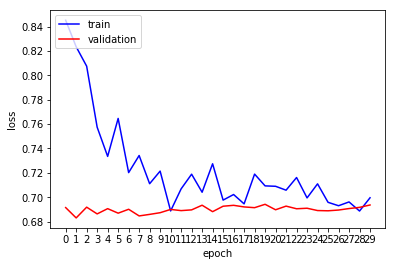

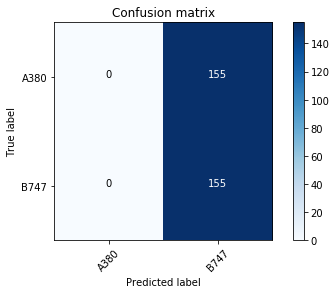

In [14]:
#F2 :  0.58 for lr=1e-2, image_size=128, batch_size=150, epoch=30 # val_loss begin at 4.4 and acc stay at 0.50 
#F2 :  0.02 for lr=1e-3, image_size=128, batch_size=256, epoch=30 # very erratic graph
#F2 :  0.55 for lr=1e-4, image_size=128, batch_size=256, epoch=30
#F2 :  0.11 for lr=1e-5, image_size=128, batch_size=256, epoch=30
#F2 :  0.55 for lr=1e-4, image_size=128, batch_size=128, epoch=30
#F2 :  0.49 (56.12 %) for lr=1e-4, image_size=128, batch_size=64
#F2 :  0.55 (49.35 %) for lr=1e-4, image_size=128, batch_size=64

lr=1e-4
image_size=128
batch_size=64
epoch=30
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, image_size), bs=batch_size, num_workers=num_cpus())
vals_s2s, global_results = learn.fit(lr, n_cycle=epoch, get_ep_vals=True)
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5, pretrained=False)
print("After ", str(len(global_results)), " epochs, the accuracy is ", str(vals_s2s[1]*100)[:5], "%" )
plot_ep_vals(global_results)
plot_the_confusion_matrix()

In [15]:
#learn.sched.plot_loss()

The model had learn quite nothing. But it is not surprising with so small dataset.

## Fine tuning

epoch      trn_loss   val_loss   accuracy                  
    0      0.923266   0.764038   0.470968  
    1      0.893703   0.72456    0.532258                  
    2      0.8488     0.70158    0.558065                  
    3      0.817575   0.682215   0.593548                  
    4      0.779626   0.653526   0.622581                  
    5      0.732367   0.628636   0.645161                  
    6      0.691451   0.627657   0.658065                  
    7      0.651018   0.618043   0.664516                  
    8      0.622816   0.595061   0.674194                  
    9      0.58657    0.582332   0.674194                  
    10     0.557019   0.576289   0.677419                  
    11     0.524184   0.568349   0.7                       
    12     0.489146   0.555976   0.693548                  
    13     0.456578   0.558912   0.709677                  
    14     0.442864   0.538553   0.732258                  
    15     0.416103   0.545191   0.735484               

array([[138,  17],
       [ 52, 103]])

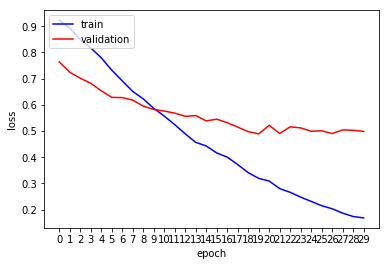

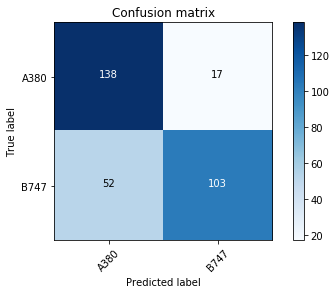

In [16]:
!rm -r {PATH}tmp

#F2 :  0.83 for image_size=128, batch_size=128, lr=1e-2
# F2 :  0.80 for image_size=128, batch_size=150, lr=1e-3
# F2 :  0.76 for image_size=128, batch_size=150, lr=1e-4 # good graph
# F2 :  0.83 for image_size=128, batch_size=150, lr=1e-2 # val loss goes up => overfitting
# F2 :  0.81 (acc 81.61 %) for image_size=128, batch_size=150, lr=1e-3 # val_loss go down, then slowly up
# F2 :  0.76 (acc 76.45 %) for image_size=128, batch_size=64, lr=1e-4 # good graph, val_loss slowly go down
# F2 :  0.76 (acc 77.74 %) for image_size=128, batch_size=64, lr=1e-4 # good graph, val_loss slowly go down

image_size=128
batch_size=64
lr=1e-4
epoch=30
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, image_size), bs=batch_size, num_workers=num_cpus())
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5, pretrained=True)
learn.unfreeze()
vals_s2s, global_results = learn.fit(lr, n_cycle=epoch, get_ep_vals=True)
print("After ", str(len(global_results)), " epochs, the accuracy is ", str(vals_s2s[1]*100)[:5], "%" )
plot_ep_vals(global_results)
plot_the_confusion_matrix()

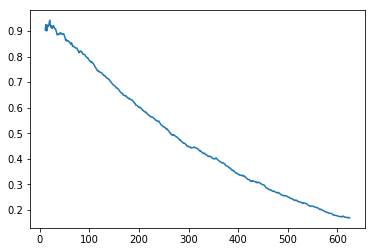

In [17]:
learn.sched.plot_loss()

Fine tunning realy improve the accuracy, it is the first thing to do with any project.

## Data augmentation
Apply random operations on pictures to help the model to generalize.
Data augmentation options : https://becominghuman.ai/data-augmentation-using-fastai-aefa88ca03f1

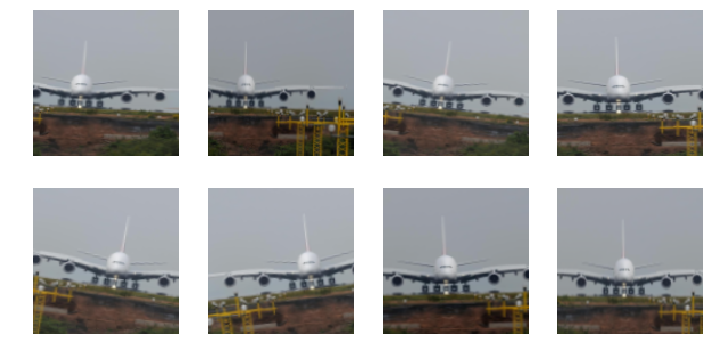

In [5]:
aug_tfms=[RandomRotate(10, tfm_y=TfmType.NO),
        RandomFlip(),
        RandomLighting(0.05, 0.05,tfm_y=TfmType.NO),
        RandomZoom(zoom_max=0.2),
        RandomStretch(max_stretch=0.2)]
tfms = tfms_from_model(arch, image_size, aug_tfms=aug_tfms, max_zoom=1.1)


def get_augs():
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=2, num_workers=2)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

ims = np.stack([get_augs() for i in range(8)])
plots(ims, rows=2)

rm: cannot remove '../../datasets/boeing_vs_airbus/tmp': No such file or directory


epoch      trn_loss   val_loss   accuracy                  
    0      0.879203   0.663855   0.609677  
    1      0.775928   0.649857   0.648387                  
    2      0.689367   0.570731   0.703226                  
    3      0.603366   0.536432   0.735484                  
    4      0.527244   0.547701   0.735484                  
    5      0.448049   0.536477   0.767742                  
    6      0.371059   0.51591    0.780645                  
    7      0.315663   0.520745   0.790323                  
    8      0.267559   0.51094    0.812903                  
    9      0.222139   0.497665   0.793548                  
    10     0.183003   0.510709   0.829032                  
    11     0.152233   0.49205    0.809677                  
    12     0.125265   0.508712   0.825806                  
    13     0.108514   0.498495   0.822581                  
    14     0.09483    0.482944   0.848387                   
    15     0.095366   0.501532   0.835484              

array([[135,  20],
       [ 28, 127]])

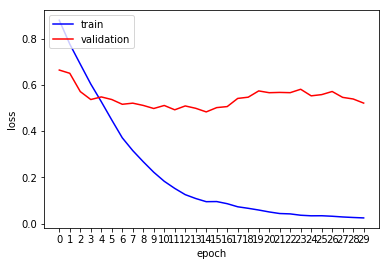

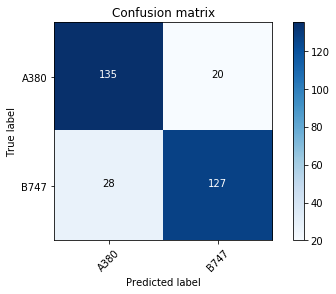

In [6]:
!rm -r {PATH}tmp
# F2 :  0.77 for image_size=128, batch_size=64, lr=1e-2 # val_loss don't go down
# F2 :  0.83 for image_size=128, batch_size=128, lr=1e-3, epoch=30
# F2 :  0.75 for image_size=128, batch_size=256, lr=1e-4, epoch=30
# F2 :  0.81 for image_size=128, batch_size=64, lr=1e-4 # good graph
# F2 :  0.85 (acc 84.19 %) for image_size=128, batch_size=64, lr=1e-3 # val_loss go slowy up
# F2 :  0.79 (acc 76.45 %) for image_size=128, batch_size=64, lr=1e-4 # val_loss still go down
# F2 :  0.84 (acc 85.16 %) for image_size=128, batch_size=64, lr=1e-3 # val_loss go slowy up

image_size=128
batch_size=64
lr=1e-3
epoch=30

data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=batch_size, num_workers=num_cpus())
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5, pretrained=True)
learn.unfreeze()
vals_s2s, global_results = learn.fit(lr, n_cycle=epoch, get_ep_vals=True)
print("After ", str(len(global_results)), " epochs, the accuracy is ", str(vals_s2s[1]*100)[:5], "%" )
plot_ep_vals(global_results)
plot_the_confusion_matrix()

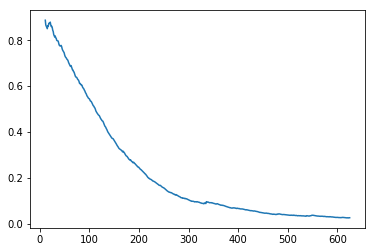

In [7]:
learn.sched.plot_loss()

Using data augmentation improve the accuracy by 10 points.

## Multiple size

epoch      trn_loss   val_loss   accuracy                  
    0      0.90379    0.769732   0.5       

After  1  epochs, the accuracy is  50.0 %
Saving to  resnext50_1_300_acc50.0_weights


epoch      trn_loss   val_loss   accuracy                  
    0      0.841389   0.71578    0.545161  
    1      0.803352   0.689751   0.603226                  
    2      0.735347   0.651809   0.635484                  
    3      0.707431   0.631154   0.658065                  
    4      0.683223   0.628723   0.677419                  
    5      0.653754   0.606118   0.683871                  
    6      0.633024   0.591384   0.696774                  
    7      0.602371   0.576686   0.709677                  
    8      0.585378   0.56637    0.719355                  
    9      0.569057   0.553641   0.729032                  

After  11  epochs, the accuracy is  72.90 %
Saving to  resnext50_11_64_acc72.90_weights


epoch      trn_loss   val_loss   accuracy                  
    0      0.522441   0.549417   0.732258  
    1      0.491588   0.546166   0.73871                   
    2      0.48012    0.545939   0.751613                  
    3      0.465077   0.534671   0.73871                   
    4      0.454      0.532276   0.758065                  
    5      0.444043   0.521254   0.748387                  
    6      0.421556   0.51817    0.764516                  
    7      0.412567   0.511466   0.758065                  
    8      0.392493   0.507449   0.754839                  
    9      0.388066   0.497662   0.767742                  

After  21  epochs, the accuracy is  76.77 %
Saving to  resnext50_21_128_acc76.77_weights


epoch      trn_loss   val_loss   accuracy                  
    0      0.347795   0.49562    0.774194  
    1      0.331653   0.498423   0.774194                  
    2      0.330152   0.496011   0.770968                  
    3      0.334662   0.485665   0.783871                  
    4      0.326422   0.484748   0.787097                  
    5      0.316567   0.478545   0.803226                  
    6      0.293861   0.484755   0.796774                  
    7      0.28421    0.483674   0.803226                  
    8      0.279678   0.479997   0.8                       
    9      0.27924    0.47701    0.8                       

After  31  epochs, the accuracy is  80.00 %
Saving to  resnext50_31_300_acc80.00_weights
[[133  22]                                   
 [ 29 126]]
Precision :  0.8580645161290322
Recall :  0.8209876543209876
F1 :  0.8391167192429022
F2 :  0.8281444582814446


array([[133,  22],
       [ 29, 126]])

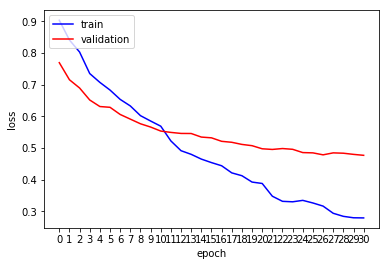

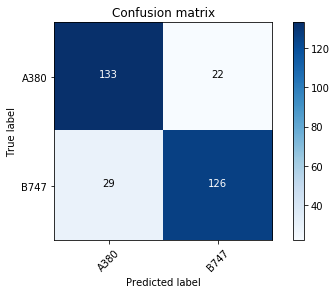

In [8]:
!rm -r {PATH}tmp
#F2 :  0.82 for learning_rate = 1e-2, dropout = [0.25,0.5], image_size = 128, batch_size = 150 # val_loss goes up
#F2 :  0.83 for learning_rate = 1e-2, dropout = 0.5, image_size = 128, batch_size = 150
#F2 :  0.61 for learning_rate = 1e-4, dropout = 0.5, image_size = 128, batch_size = 150 # bad graph
#F2 :  0.78 (acc 76.45 %) for learning_rate = 1e-3, dropout = [0.25,0.5], image_size = 128, batch_size = 150 # good graph
#F2 :  0.81 (acc 82.25 %) for learning_rate = 1e-3, dropout = [0.25,0.5], image_size = 128, batch_size = 64 # good, val_loss goes down
#F2 :  0.84 (acc 82.58 %) for learning_rate = 1e-2, dropout = [0.25,0.5], image_size = 128, batch_size = 64 # better acc but val_loss goes up


learning_rate = 1e-3
dropout = 0.5 #[0.25,0.5]
image_size = 128
batch_size = 64

global_results = collections.OrderedDict([])
aug_tfms=[RandomRotate(10, tfm_y=TfmType.NO), RandomFlip(), RandomLighting(0.05, 0.05,tfm_y=TfmType.NO), RandomZoom(zoom_max=0.2),RandomStretch(max_stretch=0.2)]
tfms = tfms_from_model(arch, image_size, aug_tfms=aug_tfms, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=batch_size, num_workers=num_cpus())
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=dropout, pretrained=True)
learn.unfreeze()
training_loop = [
    [123, 300, 1],
    [512, 64, 10],
    [150, 128, 10],
    [123, 300, 10],
]

for bs, sz, epoch in training_loop:
    lr=np.array([learning_rate/100,learning_rate/10,learning_rate]) # Learning rate plus faible pour les premières couche, pour ré-apprendre un peu si necessaire
    tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=0.5)
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=num_cpus())
    vals_s2s, ep_vals_s2s = learn.fit(lr, n_cycle=epoch, get_ep_vals=True)
    if len(global_results) > 0:
        #print(global_results)
        for k, v in ep_vals_s2s.items():
            global_results[len(global_results)] = v
    else:
        global_results = ep_vals_s2s
    print("After ", str(len(global_results)), " epochs, the accuracy is ", str(vals_s2s[1]*100)[:5], "%" )
    fichier = arch.__name__ + '_' + str(len(global_results)) + "_" + str(sz) + "_acc" + str(vals_s2s[1]*100)[:5] + '_weights'
    print("Saving to ", fichier)
    learn.save(fichier)
plot_ep_vals(global_results)
plot_the_confusion_matrix()

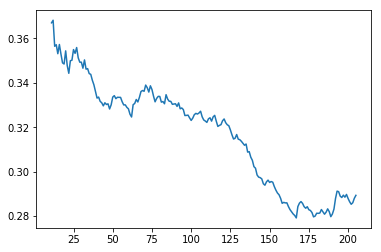

In [9]:
learn.sched.plot_loss()

Well, using multiple size did not realy help but it is something to try.

## SGDR - Learning rate anealing

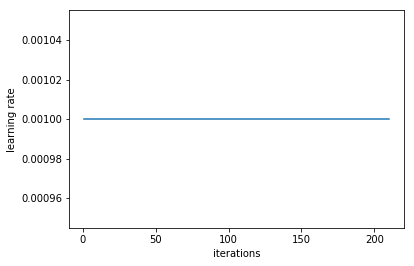

In [10]:
learn.sched.plot_lr()

Hyperparameters : Batch size= 123  Drop out= 0.5  Learning rate= 0.001  Cycle= 1  Images sizes= 300


epoch      trn_loss   val_loss   accuracy                    
    0      0.763856   0.595927   0.658065  

After  1  epochs, the accuracy is  65.80 %
Saving to  resnext50_1_300_acc65.80_weights
Hyperparameters : Batch size= 512  Drop out= 0.5  Learning rate= 0.001  Cycle= 10  Images sizes= 64


epoch      trn_loss   val_loss   accuracy                    
    0      0.616918   0.502002   0.745161  
    1      0.502727   0.417364   0.783871                    
    2      0.405798   0.391804   0.796774                    
    3      0.366143   0.447775   0.770968                    
    4      0.30131    0.38753    0.812903                    
    5      0.271372   0.339632   0.851613                    
    6      0.257093   0.288483   0.877419                    
    7      0.241783   0.367187   0.822581                    
    8      0.210236   0.277087   0.870968                    
    9      0.192285   0.2327     0.903226                    

After  11  epochs, the accuracy is  90.32 %
Saving to  resnext50_11_64_acc90.32_weights
Hyperparameters : Batch size= 150  Drop out= 0.5  Learning rate= 0.001  Cycle= 10  Images sizes= 128


epoch      trn_loss   val_loss   accuracy                    
    0      0.169191   0.187611   0.935484  
    1      0.181548   0.19815    0.912903                    
    2      0.16918    0.181096   0.932258                    
    3      0.154152   0.188716   0.916129                    
    4      0.135205   0.189789   0.919355                    
    5      0.195578   0.16577    0.93871                     
    6      0.163384   0.215804   0.916129                    
    7      0.153961   0.210454   0.909677                    
    8      0.132488   0.210455   0.903226                    
    9      0.129102   0.23563    0.916129                    

After  21  epochs, the accuracy is  91.61 %
Saving to  resnext50_21_128_acc91.61_weights
Hyperparameters : Batch size= 123  Drop out= 0.5  Learning rate= 0.001  Cycle= 10  Images sizes= 300


epoch      trn_loss   val_loss   accuracy                    
    0      0.155466   0.235876   0.912903  
    1      0.111842   0.233102   0.919355                    
    2      0.126958   0.238223   0.9                          
    3      0.098072   0.246749   0.912903                     
    4      0.128168   0.267102   0.887097                    
    5      0.103969   0.204562   0.916129                    
    6      0.087091   0.166962   0.932258                     
    7      0.102105   0.189923   0.925806                     
    8      0.123026   0.194256   0.909677                     
    9      0.098036   0.220532   0.909677                     

After  31  epochs, the accuracy is  90.96 %
Saving to  resnext50_31_300_acc90.96_weights


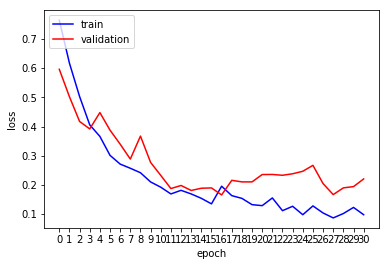

In [11]:
!rm -r {PATH}tmp

# SGDR : Earlier we said 3 is the number of epochs, but it is actually *cycles*. So if cycle_len=2 , it will do 3 cycles where each cycle is 2 epochs (i.e. 6 epochs). Then why did it 7? It is because of cycle_mult :
#     cycle_mult=2 : this multiplies the length of the cycle after each cycle (1 epoch + 2 epochs + 4 epochs = 7 epochs).

# F2 :  0.81 for learning_rate = 1e-4, lr=np.array([learning_rate/100,learning_rate/10,learning_rate]), dropout = [0.25,0.5] 
# F2 :  0.91 for learning_rate = 1e-4, lr=np.array([learning_rate/5,learning_rate/3,learning_rate]), dropout = [0.25,0.5] # good graph
# F2 :  0.93 (acc 94.51 %) for learning_rate = 1e-3, lr=np.array([learning_rate/5,learning_rate/3,learning_rate]), dropout = [0.25,0.5]
# F2 :  0.69 (acc 69.35 %) for learning_rate = 1e-2, lr=np.array([learning_rate/5,learning_rate/3,learning_rate]), dropout = [0.25,0.5] # graphs erratic but goes down
# F2 :  0.93 (acc 91.93 %) for learning_rate = 1e-3, lr=np.array([learning_rate/5,learning_rate/3,learning_rate]), dropout = [0.25,0.5] # graphs erratic at the end but goes down
# F2 :  0.94 (acc 93.54 %) for learning_rate = 1e-3, lr=np.array([learning_rate/5,learning_rate/3,learning_rate]), dropout = 0.5


learning_rate = 1e-3
lr=np.array([learning_rate/5,learning_rate/3,learning_rate])
dropout = 0.5
#[0.25,0.5] 


aug_tfms=[RandomRotate(10, tfm_y=TfmType.NO),RandomFlip(),RandomLighting(0.05, 0.05,tfm_y=TfmType.NO), RandomZoom(zoom_max=0.2), RandomStretch(max_stretch=0.2)]
tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=8, num_workers=num_cpus())
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5)
learn.unfreeze()
learn.ps=dropout
global_results = collections.OrderedDict([])

training_loop = [
    [512, 64, 10],
    [150, 128, 10],
    [123, 300, 10],
]

for bs, sz, epoch in training_loop:
    print("Hyperparameters : Batch size=", bs, " Drop out=", dropout, " Learning rate=", learning_rate, " Cycle=", epoch, " Images sizes=", sz )
    tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=0.5)
    # On recharge les données avec une taille de batch plus importante pour aller plus vite
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=num_cpus())
    vals_s2s, ep_vals_s2s = learn.fit(lr, n_cycle=epoch, cycle_len=1, get_ep_vals=True)
    if len(global_results) > 0:
        for k, v in ep_vals_s2s.items(): global_results[len(global_results)] = v
    else:
        global_results = ep_vals_s2s
    print("After ", str(len(global_results)), " epochs, the accuracy is ", str(vals_s2s[1]*100)[:5], "%" )
    fichier = arch.__name__ + '_' + str(len(global_results)) + "_" + str(sz) + "_acc" + str(vals_s2s[1]*100)[:5] + '_weights'
    print("Saving to ", fichier)
    learn.save(fichier)
plot_ep_vals(global_results)


[[153   2]                                   
 [ 19 136]]
Precision :  0.9870967741935484
Recall :  0.8895348837209303
F1 :  0.9357798165137615
F2 :  0.9074733096085409


array([[153,   2],
       [ 19, 136]])

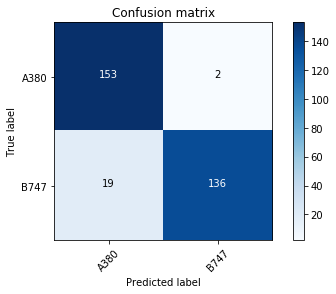

In [12]:
plot_the_confusion_matrix()

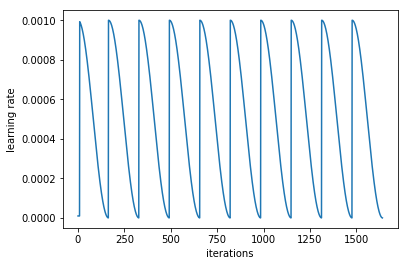

In [13]:
learn.sched.plot_lr()

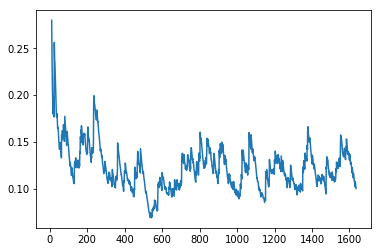

In [14]:
learn.sched.plot_loss()

OK, that give us another 10 points improvement !

## Variable cycle length

In [29]:
!rm -r {PATH}tmp

learning_rate = 1e-3
lr=np.array([learning_rate/10,learning_rate/5,learning_rate])
dropout = 0.5
#F2 :  0.96 for learning_rate = 1e-3, lr=np.array([learning_rate/10,learning_rate/5,learning_rate]), dropout = 0.5
#F2 :  0.92 for learning_rate = 1e-3, lr=np.array([learning_rate/10,learning_rate/5,learning_rate]), dropout = [0.25,0.5]
#F2 :  0.86 for learning_rate = 1e-2, lr=np.array([learning_rate/10,learning_rate/5,learning_rate]), dropout = 0.5
#F2 :  0.88 (acc 90    %) for learning_rate = 1e-3, lr=np.array([learning_rate/5,learning_rate/3,learning_rate]), dropout = 0.5 # graph go slowly down, better result at 29 epoch than 44
#F2 :  0.96 (acc 94.83 %) for learning_rate = 1e-3, lr=np.array([learning_rate/10,learning_rate/5,learning_rate]), dropout = 0.5
#F2 :  0.94 (acc 91.93 %) for learning_rate = 1e-3, lr=np.array([learning_rate/50,learning_rate/10,learning_rate]), dropout = 0.5
#F2 :  0.93 (acc 90.96 %) for learning_rate = 1e-3, lr=np.array([learning_rate/15,learning_rate/6,learning_rate]), dropout = 0.5


aug_tfms=[RandomRotate(10, tfm_y=TfmType.NO),RandomFlip(),RandomLighting(0.05, 0.05,tfm_y=TfmType.NO), RandomZoom(zoom_max=0.2), RandomStretch(max_stretch=0.2)]
tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=8, num_workers=num_cpus())
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5)
learn.unfreeze()
learn.ps=dropout
global_results = collections.OrderedDict([])

training_loop = [
    [512, 64, 4],
    [256, 128, 3],
    [123, 300, 4]
]
for bs, sz, cycle in training_loop:
    print("Hyperparameters : Batch size=", bs, " Drop out=", dropout, " Learning rate=", learning_rate, " Cycle=", cycle, " Images sizes=", sz )
    tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=0.5)
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=num_cpus())
    vals_s2s, ep_vals_s2s = learn.fit(lr, cycle, cycle_len=1, cycle_mult=2, get_ep_vals=True)
    if len(global_results) > 0:
        for k, v in ep_vals_s2s.items(): global_results[len(global_results)] = v
    else:
        global_results = ep_vals_s2s
    print("After ", str(len(global_results)), " epochs, the accuracy is ", str(vals_s2s[1]*100)[:5], "%" )
    fichier = arch.__name__ + '_' + str(len(global_results)) + "_" + str(sz) + "_acc" + str(vals_s2s[1]*100)[:5] + '_weights'
    print("Saving to ", fichier)
    learn.save(fichier)


Hyperparameters : Batch size= 512  Drop out= 0.5  Learning rate= 0.001  Cycle= 4  Images sizes= 64


epoch      trn_loss   val_loss   accuracy                    
    0      0.823131   0.724826   0.522581  
    1      0.748597   0.740874   0.493548                    
    2      0.717082   0.714272   0.554839                    
    3      0.704509   0.684434   0.564516                    
    4      0.659498   0.667107   0.593548                    
    5      0.641887   0.656167   0.622581                    
    6      0.640923   0.65742    0.622581                    
    7      0.638862   0.664058   0.629032                    
    8      0.641751   0.686859   0.635484                    
    9      0.631928   0.672336   0.619355                    
    10     0.594437   0.659854   0.606452                    
    11     0.573487   0.636967   0.648387                    
    12     0.580316   0.646546   0.63871                     
    13     0.550476   0.641909   0.635484                    
    14     0.517048   0.644741   0.635484                    
After  15  epochs, the acc

epoch      trn_loss   val_loss   accuracy                    
    0      0.533351   0.651388   0.632258  
    1      0.516926   0.644762   0.616129                    
    2      0.482992   0.627595   0.648387                    
    3      0.514349   0.659252   0.680645                    
    4      0.498489   0.631871   0.667742                    
    5      0.48535    0.620412   0.670968                    
    6      0.463351   0.599284   0.703226                    
After  22  epochs, the accuracy is  70.32 %
Saving to  resnext50_22_128_acc70.32_weights
Hyperparameters : Batch size= 123  Drop out= 0.5  Learning rate= 0.001  Cycle= 4  Images sizes= 300


epoch      trn_loss   val_loss   accuracy                    
    0      0.476458   0.606984   0.693548  
    1      0.464239   0.596235   0.706452                    
    2      0.404743   0.585383   0.690323                    
    3      0.509432   0.610487   0.687097                    
    4      0.480405   0.618674   0.687097                    
    5      0.446556   0.62198    0.687097                    
    6      0.398756   0.642116   0.687097                    
    7      0.423148   0.556793   0.725806                    
    8      0.435783   0.577357   0.735484                    
    9      0.40649    0.659821   0.741935                    
    10     0.388907   0.583633   0.722581                    
    11     0.347028   0.640025   0.7                         
    12     0.326057   0.583446   0.712903                    
    13     0.328325   0.61183    0.725806                    
    14     0.316958   0.620836   0.716129                    
After  37  epochs, the acc

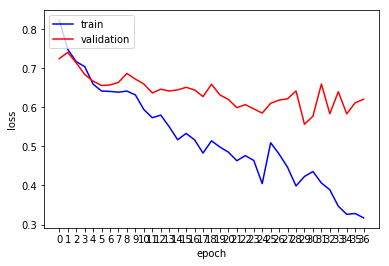

In [30]:
#plt.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
plot_ep_vals(global_results)


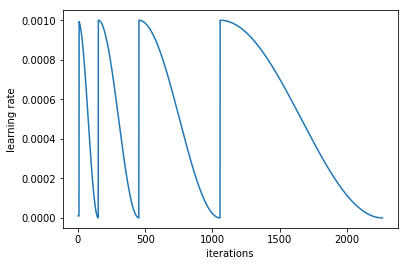

In [31]:
learn.sched.plot_lr()

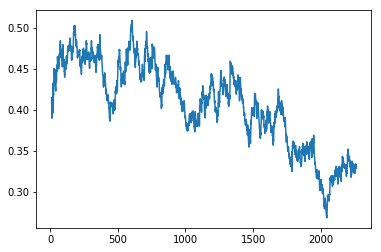

In [32]:
learn.sched.plot_loss()

[[141  14]                                   
 [ 63  92]]
Precision :  0.9096774193548387
Recall :  0.6911764705882353
F1 :  0.7855153203342619
F2 :  0.7260556127703399


array([[141,  14],
       [ 63,  92]])

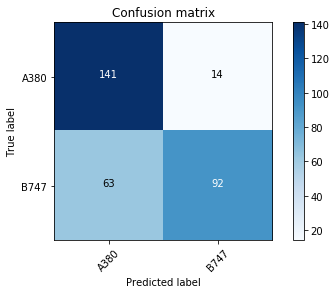

In [33]:
plot_the_confusion_matrix()

Only 2 points improvement but it's great as we are approching Google AutoML performance.

# More epochs and SWA

In [34]:
!rm -r {PATH}tmp
# resnext50 results :
#F2 :  0.95 (acc 91.29%) for learning_rate = 1e-3, lr=np.array([learning_rate/5,learning_rate/3,learning_rate]), dropout = [0.25,0.5] # 
#F2 :  0.93 (acc 91.93%) with SWA=3 for learning_rate = 1e-2, lr=np.array([learning_rate/10,learning_rate/5,learning_rate]), dropout = [0.25,0.5]XXX SWA = 3
#F2 :  0.95 (acc 91.29%) with SWA=3 for learning_rate = 1e-3, lr=np.array([learning_rate/10,learning_rate/5,learning_rate]), dropout = [0.25,0.5]
# and training_loop = [
#     [512, 64, 3, lr],
#     [256, 128, 4, lr],
#     [123, 300, 6, lr/2],
#     [64, 600, 4, lr/4]
# ]
# F2 :  0.96 (acc 95.48%), w/o SWA , learning_rate = 1e-3, [learning_rate/10,learning_rate/5,learning_rate], dropout = [0.25,0.5], 
# training_loop = [
#     [512, 64, 4],
#     [256, 128, 3],
#     [123, 300, 3],
#     [64, 600, 3],
#     [123, 300, 6],
#     [256, 128, 2],
#     [123, 300, 2],
#     [64, 600, 3],
#     [123, 400, 2]
# ]


# F2 :  0.959 (acc 95.80 %) with SWA=3 for learning_rate = 1e-3, lr=np.array([learning_rate/10,learning_rate/5,learning_rate]), dropout = [0.25,0.5]
# training_loop = [
#     [512, 64, 4, lr*2],
#     [256, 128, 3, lr],
#     [123, 300, 3, lr],
#     [64, 600, 3, lr],
#     [123, 300, 6, lr/2],
#     [64, 600, 3, lr/5],
#     [123, 400, 4, lr/5]
# ] => 121  epochs


# F2 :  0.97 96.12 % w/o SWA for learning_rate = 1e-3, lr=np.array([learning_rate/10,learning_rate/5,learning_rate]), dropout = [0.25,0.5]
# training_loop = [
#     [512, 64, 4, lr*2],
#     [256, 128, 3, lr],
#     [123, 300, 3, lr],
#     [64, 600, 3, lr],
#     [123, 300, 6, lr/2],
#     [64, 600, 3, lr/5],
#     [123, 400, 4, lr/5]
# ] => 121  epochs


# F2 :  0.92 (acc 90.32 %) for w/o SWA for learning_rate = 1e-3, lr=np.array([learning_rate/10,learning_rate/5,learning_rate]), dropout = [0.25,0.5]
# training_loop = [
#     [512, 64, 4, lr*2],
#     [256, 128, 3, lr],
#     [123, 300, 3, lr],
#     [64, 600, 3, lr],
#     [123, 300, 6, lr/2],
#     [64, 600, 3, lr/5],
#     [123, 400, 6, lr/5]
# ]
# After  169  epochs, the accuracy is  90.32 %


# F2 :  0.91 (acc 92.25 %) learning_rate = 1e-3, lr=np.array([learning_rate/10,learning_rate/5,learning_rate]), dropout = [0.25,0.5]
# training_loop = [
#     [512, 64, 4, lr*2],
#     [256, 128, 3, lr],
#     [123, 300, 6, lr/2],
#     [123, 400, 4, lr/5]
# ]
# After  100  epochs, the accuracy is  92.25 %


# F2 :  0.96 learning_rate = 1e-3, lr=np.array([learning_rate/10,learning_rate/5,learning_rate]), dropout = [0.25,0.5]
# training_loop = [
#     [512, 64, 4, lr*2],
#     [256, 128, 3, lr],
#     [123, 300, 6, lr*2]
# ]
# After  85  epochs, the accuracy is  95.48 %


#F2 :  0.95 (acc 95.48 %) for learning_rate = 1e-3, lr=np.array([learning_rate/10,learning_rate/5,learning_rate]), dropout = [0.25,0.5]
#     [512, 64, 4, lr*2],
#     [256, 128, 6, lr],
#     [123, 300, 7, lr*2]
#After  205  epochs, the accuracy is  95.48 %

# XXX SWA without cycle :
# After  80  epochs, the accuracy is  92.25 % and not improoving :(


# XXX cycle_len=2, cycle_mult=3
#     [512, 64, 4, lr],
#     [256, 128, 4, lr],
#     [123, 300, 6, lr]
# After  888  epochs, the accuracy is  96.12 % and not improoving :(

# resnet34 result :
    # F2 :  0.86 for learning_rate = 1e-3, lr=np.array([learning_rate/10,learning_rate/5,learning_rate]), dropout = [0.25,0.5]
    
    
learning_rate = 1e-3
lr=np.array([learning_rate/10,learning_rate/5,learning_rate])
dropout = [0.25,0.5]
aug_tfms=[RandomRotate(10, tfm_y=TfmType.NO),RandomFlip(),RandomLighting(0.05, 0.05,tfm_y=TfmType.NO), RandomZoom(zoom_max=0.2), RandomStretch(max_stretch=0.2)]
tfms = tfms_from_model(arch, 299, aug_tfms=aug_tfms, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=8, num_workers=num_cpus())
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5)
learn.unfreeze()
learn.ps=dropout
global_results = collections.OrderedDict([])

training_loop = [
    [512, 64, 5, lr],
    [256, 128, 5, lr],
    [123, 300, 5, lr],
    [123, 400, 5, lr],
    [123, 300, 4, lr],
    [123, 300, 4, lr],
    [123, 300, 4, lr],
    [123, 300, 4, lr],
    [123, 300, 4, lr],
    [123, 300, 4, lr],
    [123, 300, 4, lr],
    [123, 300, 4, lr],
    [123, 300, 4, lr]
    #[123, 400, 4, lr*5]
]

i = 0
for bs, sz, cycle, lr in training_loop:
    i+=1
    tfms = tfms_from_model(arch, sz, aug_tfms=aug_tfms, max_zoom=0.5)
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=num_cpus())
    vals_s2s, ep_vals_s2s = learn.fit(lr, cycle, get_ep_vals=True,
        best_save_name=arch.__name__ + "-" + str(i) + "_bestmodel", cycle_len=3, cycle_mult=2) # , # , use_swa=True, swa_start=3
    if len(global_results) > 0:
        for k, v in ep_vals_s2s.items(): global_results[len(global_results)] = v
    else:
        global_results = ep_vals_s2s
    print("After ", str(len(global_results)), " epochs, the accuracy is ", str(vals_s2s[1]*100)[:5], "%" )
    print(" with hyperparameters for ", arch.__name__, " : Batch size=", bs, " Drop out=", dropout, " Learning rate=", lr, " Cycle=", cycle, " Images sizes=", sz )
    fichier = "acc" + str(vals_s2s[1]*100)[:5] + '_' + arch.__name__ + '_' + str(len(global_results)) + "_" + str(sz) + '_weights'
    print(" Saving to ", fichier)
    learn.save(fichier)



epoch      trn_loss   val_loss   accuracy                    
    0      0.663204   0.57189    0.703226  
    1      0.495619   0.446154   0.764516                    
    2      0.43536    0.476425   0.748387                    
    3      0.351731   0.345105   0.858065                    
    4      0.333866   0.284232   0.880645                    
    5      0.257959   0.227139   0.909677                    
    6      0.201703   0.207368   0.912903                    
    7      0.199175   0.208732   0.919355                    
    8      0.17373    0.198797   0.916129                    
    9      0.243996   0.211069   0.9                         
    10     0.171877   0.189708   0.932258                    
    11     0.177079   0.157691   0.932258                    
    12     0.16199    0.211403   0.896774                    
    13     0.133979   0.150143   0.941935                    
    14     0.102432   0.14365    0.954839                     
    15     0.118454   0.1

epoch      trn_loss   val_loss   accuracy                     
    0      0.09299    0.141379   0.93871   
    1      0.067279   0.143645   0.945161                     
    2      0.086438   0.165976   0.929032                     
    3      0.072378   0.153733   0.945161                     
    4      0.092408   0.150306   0.945161                     
    5      0.076503   0.159593   0.929032                     
    6      0.066822   0.137925   0.941935                     
    7      0.042645   0.142561   0.948387                     
    8      0.040783   0.138762   0.935484                     
    9      0.066283   0.151543   0.929032                     
    10     0.072595   0.146066   0.932258                     
    11     0.096543   0.129538   0.951613                     
    12     0.100319   0.141515   0.941935                     
    13     0.088274   0.1483     0.935484                     
    14     0.076022   0.13385    0.941935                     
    15     

epoch      trn_loss   val_loss   accuracy                     
    0      0.048272   0.121176   0.948387  
    1      0.079496   0.13037    0.948387                     
    2      0.034597   0.120401   0.945161                     
    3      0.02448    0.128572   0.93871                      
    4      0.048611   0.178384   0.929032                     
    5      0.075921   0.113672   0.954839                     
    6      0.077441   0.107588   0.954839                     
    7      0.087894   0.107809   0.951613                     
    8      0.075285   0.107344   0.954839                     
    9      0.088151   0.10976    0.958065                     
    10     0.042558   0.126882   0.945161                     
    11     0.035201   0.123506   0.96129                      
    12     0.054829   0.186994   0.93871                      
    13     0.04328    0.13426    0.948387                     
    14     0.065683   0.145168   0.93871                      
    15     

epoch      trn_loss   val_loss   accuracy                     
    0      0.040553   0.107976   0.964516  
    1      0.026576   0.111309   0.945161                     
    2      0.023087   0.100293   0.954839                     
    3      0.027736   0.096336   0.974194                     
    4      0.035504   0.091071   0.96129                      
    5      0.030421   0.092172   0.96129                      
    6      0.037233   0.186978   0.919355                     
    7      0.090749   0.105826   0.958065                     
    8      0.050852   0.091398   0.970968                     
    9      0.066422   0.120956   0.958065                     
    10     0.035106   0.109161   0.954839                     
    11     0.014558   0.114083   0.964516                     
    12     0.024133   0.115597   0.964516                     
    13     0.027797   0.122936   0.954839                     
    14     0.030221   0.132224   0.93871                      
    15     

epoch      trn_loss   val_loss   accuracy                     
    0      0.088762   0.104636   0.96129   
    1      0.027641   0.089289   0.967742                     
    2      0.015971   0.095576   0.964516                     
    3      0.014926   0.121748   0.954839                     
    4      0.01907    0.114287   0.954839                     
    5      0.037672   0.101042   0.96129                      
    6      0.048279   0.113758   0.951613                     
    7      0.094751   0.112502   0.945161                     
    8      0.034102   0.14296    0.93871                      
    9      0.023437   0.090682   0.964516                     
    10     0.037426   0.104657   0.951613                     
    11     0.014937   0.113851   0.954839                     
    12     0.016237   0.112134   0.958065                      
    13     0.045082   0.099585   0.96129                      
    14     0.028816   0.128125   0.948387                     
    15    

epoch      trn_loss   val_loss   accuracy                     
    0      0.012841   0.132439   0.954839  
    1      0.017117   0.120125   0.954839                     
    2      0.015701   0.128277   0.951613                     
    3      0.037436   0.116832   0.954839                     
    4      0.018554   0.099062   0.96129                      
    5      0.038269   0.10441    0.954839                      
    6      0.025433   0.121997   0.948387                     
    7      0.03522    0.105263   0.951613                      
    8      0.014796   0.115007   0.954839                     
    9      0.033803   0.105172   0.958065                     
    10     0.012205   0.107423   0.954839                     
    11     0.038438   0.134923   0.945161                      
    12     0.023511   0.118659   0.948387                     
    13     0.020691   0.108568   0.954839                     
    14     0.035313   0.11763    0.945161                     
    15  

epoch      trn_loss   val_loss   accuracy                      
    0      0.004768   0.099014   0.948387  
    1      0.010532   0.089316   0.96129                      
    2      0.013942   0.104742   0.954839                     
    3      0.033549   0.135032   0.948387                      
    4      0.028399   0.096114   0.951613                     
    5      0.007319   0.096182   0.945161                      
    6      0.003612   0.090193   0.954839                      
    7      0.008636   0.08961    0.958065                      
    8      0.027429   0.086487   0.958065                      
    9      0.008178   0.107491   0.954839                      
    10     0.018283   0.097195   0.964516                      
    11     0.026297   0.09713    0.954839                     
    12     0.04329    0.149454   0.945161                     
    13     0.005096   0.087056   0.954839                      
    14     0.016718   0.088157   0.958065                     
  

epoch      trn_loss   val_loss   accuracy                     
    0      0.0267     0.100139   0.96129   
    1      0.005767   0.093041   0.96129                       
    2      0.012534   0.102549   0.951613                     
    3      0.017118   0.099373   0.951613                     
    4      0.004186   0.075267   0.970968                      
    5      0.002375   0.079341   0.974194                      
    6      0.004849   0.071431   0.974194                      
    7      0.025495   0.087131   0.964516                      
    8      0.004677   0.073506   0.970968                      
    9      0.023749   0.086946   0.970968                      
    10     0.008208   0.08634    0.967742                      
    11     0.027622   0.103041   0.96129                       
    12     0.016236   0.08955    0.964516                      
    13     0.023352   0.100539   0.964516                     
    14     0.011549   0.083307   0.964516                     
 

epoch      trn_loss   val_loss   accuracy                      
    0      0.001904   0.101716   0.945161  
    1      0.003616   0.100418   0.954839                      
    2      0.0513     0.097749   0.96129                      
    3      0.024889   0.113862   0.951613                     
    4      0.006179   0.100269   0.954839                      
    5      0.01506    0.110217   0.958065                     
    6      0.004331   0.109866   0.958065                      
    7      0.005826   0.115995   0.951613                      
    8      0.006722   0.100509   0.958065                      
    9      0.009078   0.131703   0.954839                      
    10     0.006626   0.110225   0.951613                      
    11     0.045942   0.106063   0.958065                     
    12     0.00725    0.096167   0.96129                       
    13     0.031528   0.08773    0.964516                     
    14     0.003534   0.083176   0.970968                      
 

epoch      trn_loss   val_loss   accuracy                      
    0      0.010211   0.065388   0.974194  
    1      0.001992   0.078411   0.967742                      
    2      0.014379   0.073287   0.967742                     
    3      0.022129   0.071777   0.970968                      
    4      0.011057   0.114324   0.958065                      
    5      0.004192   0.072143   0.967742                      
    6      0.01527    0.075544   0.970968                     
    7      0.002391   0.096087   0.958065                      
    8      0.006476   0.084523   0.96129                       
    9      0.007729   0.073675   0.967742                      
    10     0.02454    0.084504   0.974194                     
    11     0.015515   0.090638   0.96129                      
    12     0.038154   0.089125   0.967742                     
    13     0.047415   0.151458   0.93871                       
    14     0.026218   0.084599   0.964516                      
 

epoch      trn_loss   val_loss   accuracy                      
    0      0.034684   0.067635   0.977419  
    1      0.004135   0.066201   0.977419                      
    2      0.001945   0.060709   0.977419                      
    3      0.012852   0.073482   0.970968                     
    4      0.03145    0.066258   0.967742                     
    5      0.013625   0.067394   0.970968                      
    6      0.002334   0.079778   0.967742                      
    7      0.006075   0.06474    0.970968                      
    8      0.002622   0.081406   0.974194                      
    9      0.007179   0.081582   0.970968                      
    10     0.004687   0.09396    0.958065                      
    11     0.008087   0.068115   0.967742                      
    12     0.020467   0.094021   0.96129                       
    13     0.029114   0.079194   0.970968                      
    14     0.004053   0.071327   0.977419                     

epoch      trn_loss   val_loss   accuracy                      
    0      0.060986   0.127253   0.964516  
    1      0.005248   0.112018   0.948387                      
    2      0.010717   0.115574   0.954839                     
    3      0.001982   0.115803   0.941935                      
    4      0.037779   0.099857   0.954839                      
    5      0.010458   0.112571   0.954839                     
    6      0.005467   0.109257   0.958065                      
    7      0.024046   0.109656   0.96129                      
    8      0.007971   0.104135   0.954839                      
    9      0.00147    0.104475   0.958065                      
    10     0.002325   0.119467   0.951613                      
    11     0.013811   0.112571   0.96129                      
    12     0.004791   0.106207   0.958065                      
    13     0.002798   0.101314   0.958065                      
    14     0.028283   0.105665   0.954839                      


epoch      trn_loss   val_loss   accuracy                      
    0      0.010837   0.103506   0.958065  
    1      0.014922   0.116257   0.958065                      
    2      0.056145   0.115565   0.951613                      
    3      0.044611   0.209679   0.932258                     
    4      0.00827    0.144881   0.945161                      
    5      0.005675   0.110978   0.948387                      
    6      0.043745   0.125318   0.951613                      
    7      0.005693   0.148854   0.941935                      
    8      0.04834    0.139049   0.941935                     
    9      0.008291   0.123562   0.948387                      
    10     0.004249   0.124453   0.958065                      
    11     0.020823   0.112113   0.954839                     
    12     0.051805   0.108607   0.948387                     
    13     0.008242   0.115347   0.954839                      
    14     0.002542   0.114895   0.948387                      


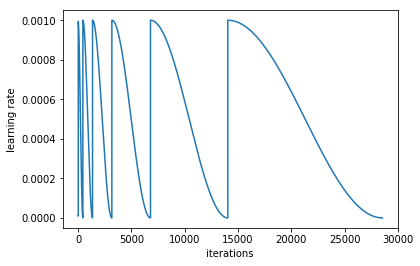

In [35]:
learn.sched.plot_lr()

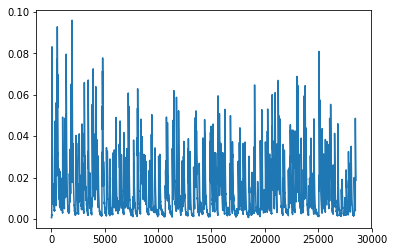

In [36]:
learn.sched.plot_loss()

<Figure size 1120x640 with 0 Axes>

[[150   5]                                   
 [  1 154]]
Precision :  0.967741935483871
Recall :  0.9933774834437086
F1 :  0.9803921568627451
F2 :  0.9881422924901185


array([[150,   5],
       [  1, 154]])

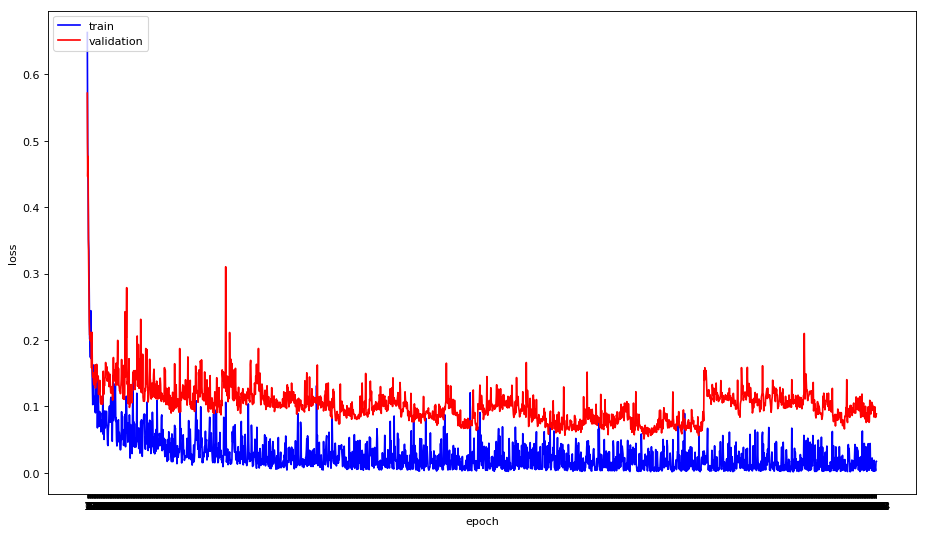

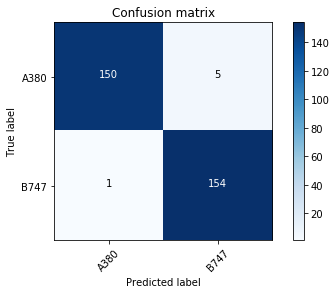

In [37]:

plt.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
plot_ep_vals(global_results)
plot_the_confusion_matrix()

In [4]:
#loadmodel=False
loadmodel=True
if loadmodel==True:
    aug_tfms=[RandomRotate(10, tfm_y=TfmType.NO),RandomFlip(),RandomLighting(0.05, 0.05,tfm_y=TfmType.NO), RandomZoom(zoom_max=0.2), RandomStretch(max_stretch=0.2)]
    tfms = tfms_from_model(arch, 299, aug_tfms=aug_tfms, max_zoom=1.1)
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=8, num_workers=num_cpus())
    learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5)
    #learn.load("resnext50_141_300_acc98.06_weights")
    #learn.load("acc97.74_resnext50_1269_300_weights") # trained with same data as Google
    learn.load("resnext506_bestmodel")
    #learn.load(arch.__name__ + "_bestmodel")
    #learn.freeze()
    #learn.TTA()
    #vals_s2s, global_results = learn.fit(0.00001, n_cycle=1, get_ep_vals=True)
    #plot_ep_vals(global_results)
    print("Model chargé")

Model chargé


# Prediction et visualisation

[[149   6]                                   
 [  1 154]]
Precision :  0.9612903225806452
Recall :  0.9933333333333333
F1 :  0.9770491803278689
F2 :  0.9867549668874172


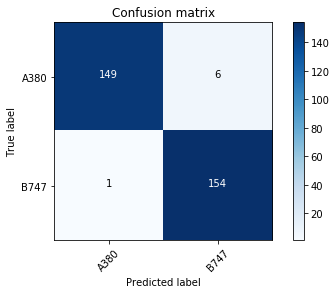

In [5]:
cm = plot_the_confusion_matrix()

In [6]:
#?plot_confusion_matrix

## Precision and Recall
Précision et rappel en français : https://fr.wikipedia.org/wiki/Pr%C3%A9cision_et_rappel
_La précision est le nombre de documents pertinents retrouvés rapporté au nombre de documents total proposé par le moteur de recherche pour une requête donnée. _ Autrement dit quelle proportion d'identifications positives était effectivement correcte ?

_Le rappel est défini par le nombre de documents pertinents retrouvés au regard du nombre de documents pertinents que possède la base de données._ Autrement dit quelle proportion de résultats positifs réels a été identifiée correctement ?

In [7]:
# precission = VP / (VP + FP)
precision = cm[0][0]/(cm[0][1]+cm[0][0]);
print("Precision : ", precision)
# recall =  = VP / (VP + FN)
recall = cm[0][0]/(cm[1][0]+cm[0][0]);
print("recall : ", recall)
F1 = 2 * ((precision*recall)/(precision + recall))
print("F1 : ", F1)
F2 = 5 * ((precision*recall)/(4*precision + recall))
print("F2 : ", F2)

Precision :  0.9612903225806452
recall :  0.9933333333333333
F1 :  0.9770491803278689
F2 :  0.9867549668874172


In [8]:
# from here we know that 'cats' is label 0 and 'dogs' is label 1.
data.classes
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape  # = (nombre de prediction , nombre de classe)
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

from math import ceil
nb_images = 6

# Récupère aléatoirement des prédictions
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], min(len(preds), nb_images), replace=False)

# Récupère les prédictions correctes
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

# Affiche les images
def plots(ims, figsize=(20,10), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=12)
        plt.imshow(ims[i])

# Charge l'image
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

# Affiche des images avec un titre
def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [(str(probs[x]) + "\n" + str(data.val_ds.fnames[x][10:][:20])) for x in idxs]
    print(title)
    nb_lignes = ceil(len(idxs) / 3)
    return plots(imgs, rows=nb_lignes, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

# Recupère les prédiction triées
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:nb_images]] # Les nb_images premiers éléments

# Recupère les prédictions les plus justes
def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

['A380', 'B747']

(310, 2)

Most incorrect A380


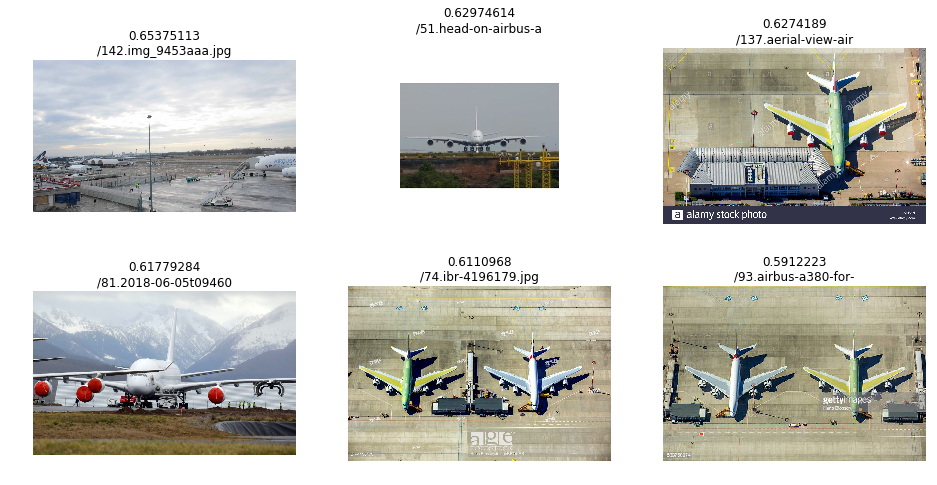

In [9]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect " + data.classes[0])

Most incorrect B747


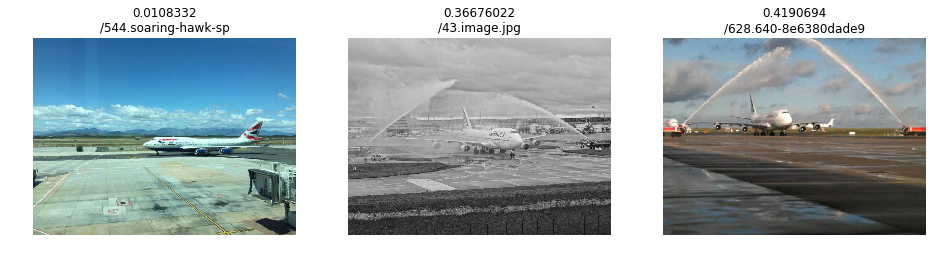

In [10]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect " + data.classes[1])

Most uncertain predictions


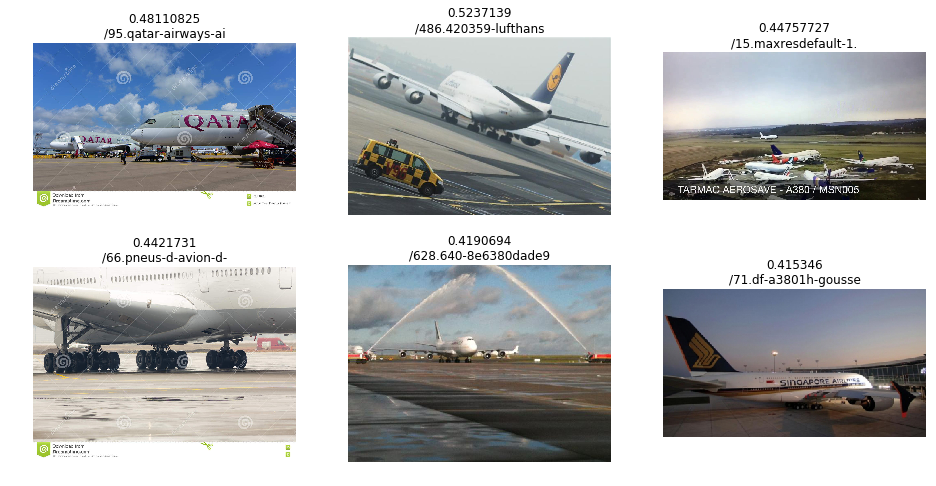

In [11]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:nb_images]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

Most correct B747


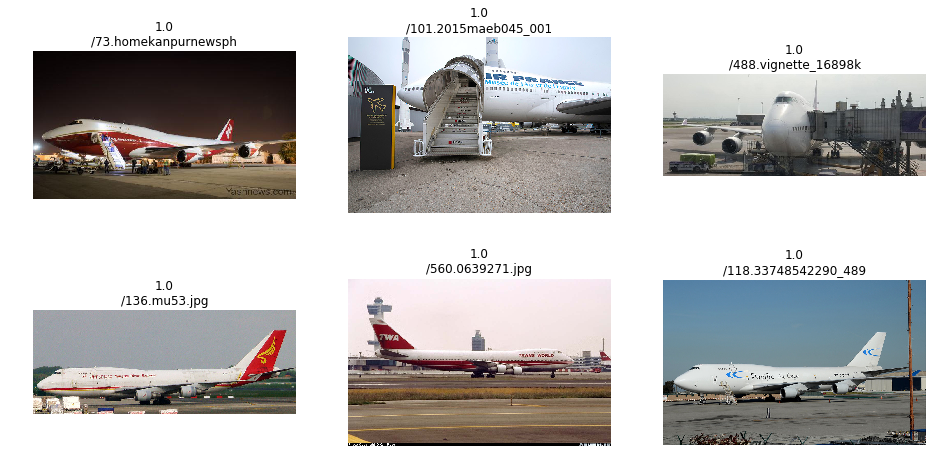

In [12]:
plot_val_with_title(most_by_correct(1, True), "Most correct " + data.classes[1])

Most correct A380


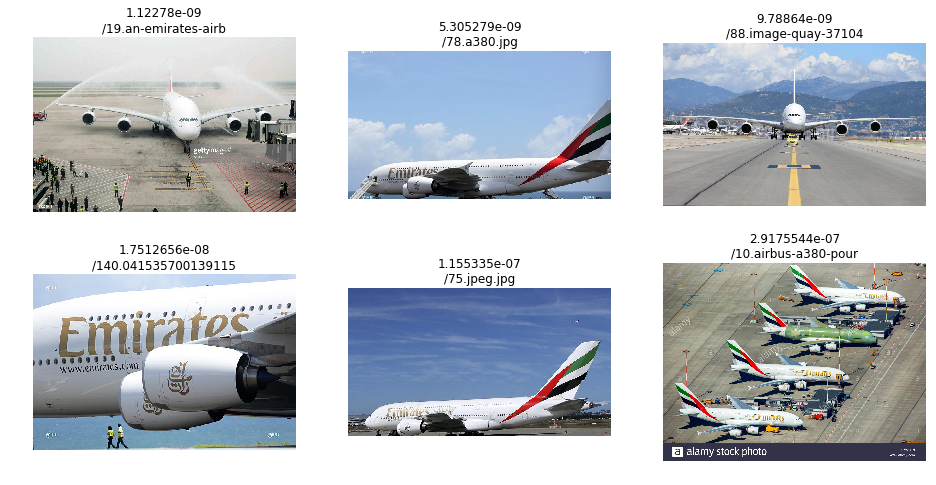

In [13]:
plot_val_with_title(most_by_correct(0, True), "Most correct " + data.classes[0])
# 1. A few correct labels at random
#plot_val_with_title(rand_by_correct(True), "Correctly classified")
# 2. A few incorrect labels at random
#plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

C'est bon, les plus petites font plus de 200 pixels.
On note que la majorité on une taille importante, il sera bon de faire des entrainement du modèle avec des tailles supérieures.

_"How many images should we use as a validation set? [01:26:28] Using 20% is fine unless the dataset is small — then 20% is not enough. If you train the same model multiple times and you are getting very different validation set results, then your validation set is too small. If the validation set is smaller than a thousand, it is hard to interpret how well you are doing. If you care about the third decimal place of accuracy and you only have a thousand things in your validation set, a single image changes the accuracy. If you care about the difference between 0.01 and 0.02, you want that to represent 10 or 20 rows. Normally 20% seems to work fine."_
=> Nous avons environs 100 images de validation par classes, ça devrait donc aller.

Faisons un test d'entrainement avec une petite taille de batch pour estimer la valeur du learning rate.

In [14]:

# !mkdir {PATH}badA380
# !mv {PATH}train/A380/8.maxresdefault.jpg {PATH}badA380/
# !mv {PATH}train/A380/11.220px-farnborough_air_show_2006_a380_landing.jpg {PATH}badA380/
# !mv {PATH}train/A380/24.81h0sfkrpgl.jpg {PATH}badA380/
# !mv {PATH}train/A380/74.main-qimg-8147ee508ce122aa5e6f5c60fc8de1b5-c.jpg {PATH}badA380/
# !mv {PATH}train/A380/85.ee8237379a16279689369a8d2303cf93928d6abd93b699c69075b2b6c69614b4bc86f4be1bbeb2bc25b48f03773aa9b6636333a023.jpg {PATH}badA380/
# !mv {PATH}train/A380/94.airbus-a380-deluxe.jpg {PATH}badA380/
# !mv {PATH}train/A380/99.airbus-a380-transport-convoy-day1-19.jpg {PATH}badA380/
# !mv {PATH}train/A380/144.1300018-airbus_a380.jpg {PATH}badA380/
# !mv {PATH}train/A380/154.emirates-airbus-a380-800-diecast-model-aircraft-a380-toy-aeroplane-1.jpg {PATH}badA380/
# !mv {PATH}train/A380/198.hqdefault.jpg {PATH}badA380/
# !mv {PATH}train/A380/209.853923124-emirates-airlines-passage-souterrain-airbus-a380-london-heathrow-airport.jpg {PATH}badA380/
# !mv {PATH}train/A380/211.img_2522.jpg {PATH}badA380/
# !mv {PATH}train/A380/237.http3a2f2fcdn.cnn.com2fcnnnext2fdam2fassets2f180103170034-a380-logistics---city-of-hamburg-roro-vessel-jun08-hr.jpg {PATH}badA380/
# !mv {PATH}train/A380/256.emirates-a380-en-fleurs.jpg {PATH}badA380/
# !mv {PATH}train/A380/261.9xd8q7-userview-0.png {PATH}badA380/
# !mv {PATH}train/A380/262.9409091-15073071.jpg {PATH}badA380/
# !mv {PATH}train/A380/297.decollage-et-atterrissage-airbus-a380-radicommande.jpg {PATH}badA380/
# !mv {PATH}train/A380/334.a380-and-boeing-747-680x365_c.jpg {PATH}badA380/
# !mv {PATH}train/A380/334.img_73181.jpg {PATH}badA380/
# !mv {PATH}train/A380/360.airbus-a380.jpg {PATH}badA380/
# !mv {PATH}train/A380/362.7802294-12095436.jpg {PATH}badA380/
# !mv {PATH}train/A380/372.htb1h1mphfxxxxc8axxxq6xxfxxxt.jpg {PATH}badA380/
# !mv {PATH}train/A380/373.a380-family.jpg {PATH}badA380/
# !mv {PATH}train/A380/376.monarch-airlines-airbus-a321-taxiing-on-manchester-airport-tarmac-f16f2m.jpg {PATH}badA380/
# !mv {PATH}train/A380/400.reacteur-en-feu-quantas-a380.jpeg {PATH}badA380/
# !mv {PATH}train/A380/401.depositphotos_131033688-stock-photo-lufthansa-airbus-a380-airplane-workers.jpg {PATH}badA380/
# !mv {PATH}train/A380/402.img_3404.jpg {PATH}badA380/
# !mv {PATH}train/A380/408.airbus-a380-envol-du-beluga.jpg {PATH}badA380/
# !mv {PATH}train/A380/409.portes-ouvertes-de-l-aeroclub-de-villars-en-presence-de-asso_3844714.jpeg {PATH}badA380/
# !mv {PATH}train/A380/428.a380-tarmaca1-324x160.jpg {PATH}badA380/
# !mv {PATH}train/A380/431.1732452-2346254.jpg {PATH}badA380/
# !mv {PATH}train/A380/431.2041395-o_19s9qcnnv11bqhha1rc9c1t1sboe-thumbnail-full.jpg {PATH}badA380/
# !mv {PATH}train/A380/453.10274f-e7986c-gta5202016-03-202001-51-36-96.png {PATH}badA380/
# !mv {PATH}train/A380/460.part-nic-nic452399-1-1-0.jpg {PATH}badA380/
# !mv {PATH}train/A380/467.un-avion-de-la-compagnie-skymark-sur-le-tarmac-de-l-aeroport-de-tokyo-le-30-juillet-2014_4982731.jpg {PATH}badA380/
# !mv {PATH}train/A380/479.ahr0cdovl3d3dy5saxzlc2npzw5jzs5jb20vaw1hz2vzl2kvmdawlzawmc82odgvb3jpz2luywwvmdywntaxx2fpcmj1c19wbgfuzv8wms5qcgc.jpg {PATH}badA380/
# !mv {PATH}train/A380/482.830x532_convoi-transportant-pieces-airbus-a380-traverse-village-levignac-haute-garonne-30-novembre-2011.jpg {PATH}badA380/
# !mv {PATH}train/A380/491.447568151-emirates-airlines-passage-souterrain-airbus-a380-london-heathrow-airport.jpg {PATH}badA380/
# !mv {PATH}train/A380/494.mieux-vaut-ne-pas-etre-sur-le-passage-d-un-a380_94741ab1d51dabd2df8b27a3439cd10eb732e763.jpg {PATH}badA380/
# !mv {PATH}train/A380/498.vista-dalla-business.jpg {PATH}badA380/
# !mv {PATH}train/A380/516.airbus-a380-900-lufthansa-4018771334_lrg.jpg {PATH}badA380/
# !mv {PATH}train/A380/533.1990802.jpg {PATH}badA380/
# !mv {PATH}train/A380/541.dsc02104.jpg {PATH}badA380/
# !mv {PATH}train/A380/545.3df3d8cd83645dbfa9bd07c5e320d0f6.jpg {PATH}badA380/
# !mv {PATH}train/A380/551.p3282113.jpg {PATH}badA380/
# !mv {PATH}train/A380/557.simulateur-de-vol-airbus-a380-800-a-linterieur-de-dubai-mall-a-dubai-emirats-arabes-unis-f4rb50.jpg {PATH}badA380/
# !mv {PATH}train/A380/564.turkish-airlines-pourrait-commander-au-moins-10-airbus-a380.jpg {PATH}badA380/
# !mv {PATH}train/A380/576.air-journal_ana-all-nippon-airways-3-a380-265x199.jpg {PATH}badA380/

In [15]:
# !mv {PATH}train/A380/405.56bb624ae7235.jpg {PATH}train/B747/
# !mv {PATH}train/A380/237.http3a2f2fcdn.cnn.com2fcnnnext2fdam2fassets2f180103170034-a380-logistics---city-of-hamburg-roro-vessel-jun08-hr.jpg {PATH}badA380/

In [16]:
# !mkdir {PATH}badB747
# !mv {PATH}train/B747/7.maxresdefault.jpg  {PATH}badB747/
# !mv {PATH}train/B747/59.img-20180411-wa0020.jpg {PATH}badB747/
# !mv {PATH}train/B747/60.boeing-747-640x374.jpg {PATH}badB747/
# !mv {PATH}train/B747/61.s-l300.jpg {PATH}badB747/
# !mv {PATH}train/B747/70.picture.jpg {PATH}badB747/
# !mv {PATH}train/B747/76.1490212251036.jpg {PATH}badB747/
# !mv {PATH}train/B747/100.boeing-747-recherche-deseperement-640x385.jpg {PATH}badB747/
# !mv {PATH}train/B747/120.prog6631381_1.jpg {PATH}badB747/
# !mv {PATH}train/B747/141.second-boeing-747-transporteur-navette-spatiale-retraite-2-e1410858111656.jpg {PATH}badB747/
# !mv {PATH}train/B747/165.boeing-747-commercial-airliner-and-cargo-transport-aircraft-united-picture-id515949821s612x612.jpg {PATH}badB747/
# !mv {PATH}train/B747/174.british-cargo.jpg {PATH}badB747/
# !mv {PATH}train/B747/179.87774058d38b23fd74b0648cf3911266.jpg {PATH}badB747/
# !mv {PATH}train/B747/195.le-boeing-747-cargo-dreamlifter-au-decollage-de-l-aeroport-de-wichita-apres-s-etre-trompe-de-destination_6fd46e6c8e66f1e9f6acbdbfeeb5c06a4ba3d9e1.jpg {PATH}badB747/
# !mv {PATH}train/B747/198.6970356-3x2-940x627.jpg {PATH}badB747/
# !mv {PATH}train/B747/199.20160712-093950.jpg {PATH}badB747/
# !mv {PATH}train/B747/203.mg_7341.jpg {PATH}badB747/
# !mv {PATH}train/B747/238.1705425.jpg {PATH}badB747/
# !mv {PATH}train/B747/229.sca20phantom20ray.jpg {PATH}badB747/
# !mv {PATH}train/B747/243.747.jpg {PATH}badB747/
# !mv {PATH}train/B747/246.2006021711572005_1.jpg {PATH}badB747/
# !mv {PATH}train/B747/250.180105114950-delta-boeing-747-marana-retirement.jpg {PATH}badB747/
# !mv {PATH}train/B747/260.img_7487.jpg {PATH}badB747/
# !mv {PATH}train/B747/261.boeing-747.jpg {PATH}badB747/
# !mv {PATH}train/B747/262.87507322-un-c3a9norme-boeing-747-l-un-des-plus-beaux-avions-du-monde-avec-sa-cellule-c3a0-deux-ponts-.jpg {PATH}badB747/
# !mv {PATH}train/B747/267.spirit-dreamlifter-750-690x377.jpg {PATH}badB747/
# !mv {PATH}train/B747/275.271px-boeing_747-40928lcf29_dreamlifter2c_n780ba_-_pae_282124141521329.jpg {PATH}badB747/
# !mv {PATH}train/B747/282.220px-an_amazing_attraction21_-_geo.hlipp.de_-_645.jpg {PATH}badB747/
# !mv {PATH}train/B747/283.f-35-and-sca.jpg {PATH}badB747/
# !mv {PATH}train/B747/291.tests-d-un-boeing-737-max-7-sur-le-tarmac-situe-devant-l-usine-boeing-de-renton.jpg {PATH}badB747/
# !mv {PATH}train/B747/309.8498120e-ff98-11e7-b3ab-75f9c0f581ba-780x520.jpg {PATH}badB747/
# !mv {PATH}train/B747/328.superstructures.jpg {PATH}badB747/
# !mv {PATH}train/B747/335.q7wn.jpg {PATH}badB747/
# !mv {PATH}train/B747/350.1009011252031096826672541.jpg {PATH}badB747/
# !mv {PATH}train/B747/351.vignette_10332uqxgngitmxgpfou_cover.jpg {PATH}badB747/
# # Avion de Trump dans les train : {PATH}badB747/
# !mv {PATH}train/B747/363.29906170001_5237579174001_5237581168001-vs.jpg {PATH}badB747/
# !mv {PATH}train/B747/366.2014-10-11-at-16-34-12-1024x575.jpg {PATH}badB747/
# !mv {PATH}train/B747/374.7003a7722cacde4eb1693d36b30913e0.jpg {PATH}badB747/
# !mv {PATH}train/B747/402.2015maeb045_001_007.jpg {PATH}badB747/
# !mv {PATH}train/B747/407.920x920.jpg {PATH}badB747/
# !mv {PATH}train/B747/409.07264ed2-b91e-4142-aa17-83da409f39b6-photo_sep_09_2_47_36_pm.jpg {PATH}badB747/
# !mv {PATH}train/B747/415.240px-boeing_747-40028lcf29_dreamlifter.jpg {PATH}badB747/
# !mv {PATH}train/B747/424.img_1954.jpg {PATH}badB747/
# !mv {PATH}train/B747/462.virgin-orbit-boeing-747.jpg {PATH}badB747/
# !mv {PATH}train/B747/472.welsh-models-whsl255v-boeing-747-133-233bm-air-canada.jpg {PATH}badB747/
# !mv {PATH}train/B747/473.loading-cargo-into-a-boeing-747-picture-id636471254.jpg {PATH}badB747/
# !mv {PATH}train/B747/485.si202008-1170h.jpg {PATH}badB747/
# !mv {PATH}train/B747/506.jav20120416170009.jpg {PATH}badB747/
# !mv {PATH}train/B747/508._61563032_aeroplane-2.jpg {PATH}badB747/
# !mv {PATH}train/B747/513.boeing-747.jpg {PATH}badB747/
# !mv {PATH}train/B747/529.scale.jpg {PATH}badB747/
# !mv {PATH}train/B747/537.boeing-747-anniversary-3-100643980-gallery.idge.jpg {PATH}badB747/
# !mv {PATH}train/B747/542.boeing-747_queue.jpg {PATH}badB747/
# !mv {PATH}train/B747/589.getpubliccontentcontentid97507163-82b4-40f6-994a-1c20b73c9a36.jpg {PATH}badB747/
# !mv {PATH}train/B747/595.avion-boeing-747-joustra.jpg {PATH}badB747/
# !mv {PATH}train/B747/599.1162_1_hlr80459_2.jpg {PATH}badB747/
# !mv {PATH}train/B747/644.depositphotos_176030442-stock-video-fedex-boeing-747-being-loading.jpg {PATH}badB747/
# !mv {PATH}train/B747/650.uta-maquette-agence-boeing-747-avec-socle-maquette-_1.jpg {PATH}badB747/
# !mv {PATH}train/B747/670.depositphotos_69241467-stock-photo-wheels-of-a-boeing-747.jpg {PATH}badB747/